In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# stock_data = pd.read_csv('ACGL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data = pd.read_csv('SBIN.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,252.500000,253.649994,242.600006,243.600006,241.416748,25988990.0
2017-01-03,244.000000,246.399994,241.100006,244.899994,242.705093,15963085.0
2017-01-04,245.800003,246.399994,242.199997,242.899994,240.723007,11225978.0
2017-01-05,245.000000,245.899994,243.699997,245.350006,243.151062,11970913.0
2017-01-06,246.000000,249.000000,245.500000,245.899994,243.696121,12354302.0
...,...,...,...,...,...,...
2019-12-24,333.200012,334.200012,329.200012,331.450012,331.450012,21747782.0
2019-12-26,333.000000,333.450012,328.100006,329.850006,329.850006,24616942.0
2019-12-27,333.399994,338.350006,333.000000,337.250000,337.250000,33477173.0


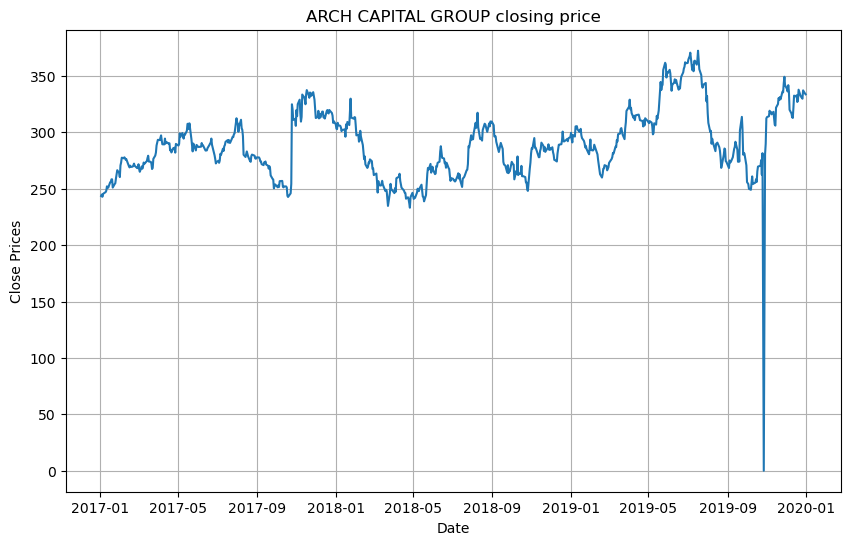

In [3]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

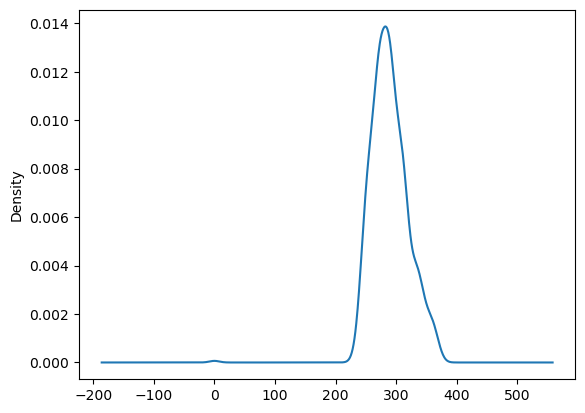

In [4]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')


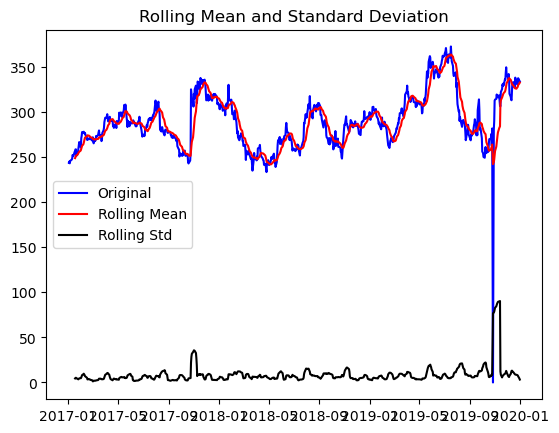

Results of dickey fuller test
Test Statistics                 -3.235084
p-value                          0.018042
No. of lags used                 4.000000
Number of observations used    732.000000
critical value (1%)             -3.439315
critical value (5%)             -2.865497
critical value (10%)            -2.568877
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

In [6]:
df_close

Date
2017-01-02    243.600006
2017-01-03    244.899994
2017-01-04    242.899994
2017-01-05    245.350006
2017-01-06    245.899994
                 ...    
2019-12-24    331.450012
2019-12-26    329.850006
2019-12-27    337.250000
2019-12-30    334.399994
2019-12-31    333.750000
Name: Close, Length: 737, dtype: float64

<Figure size 640x480 with 0 Axes>

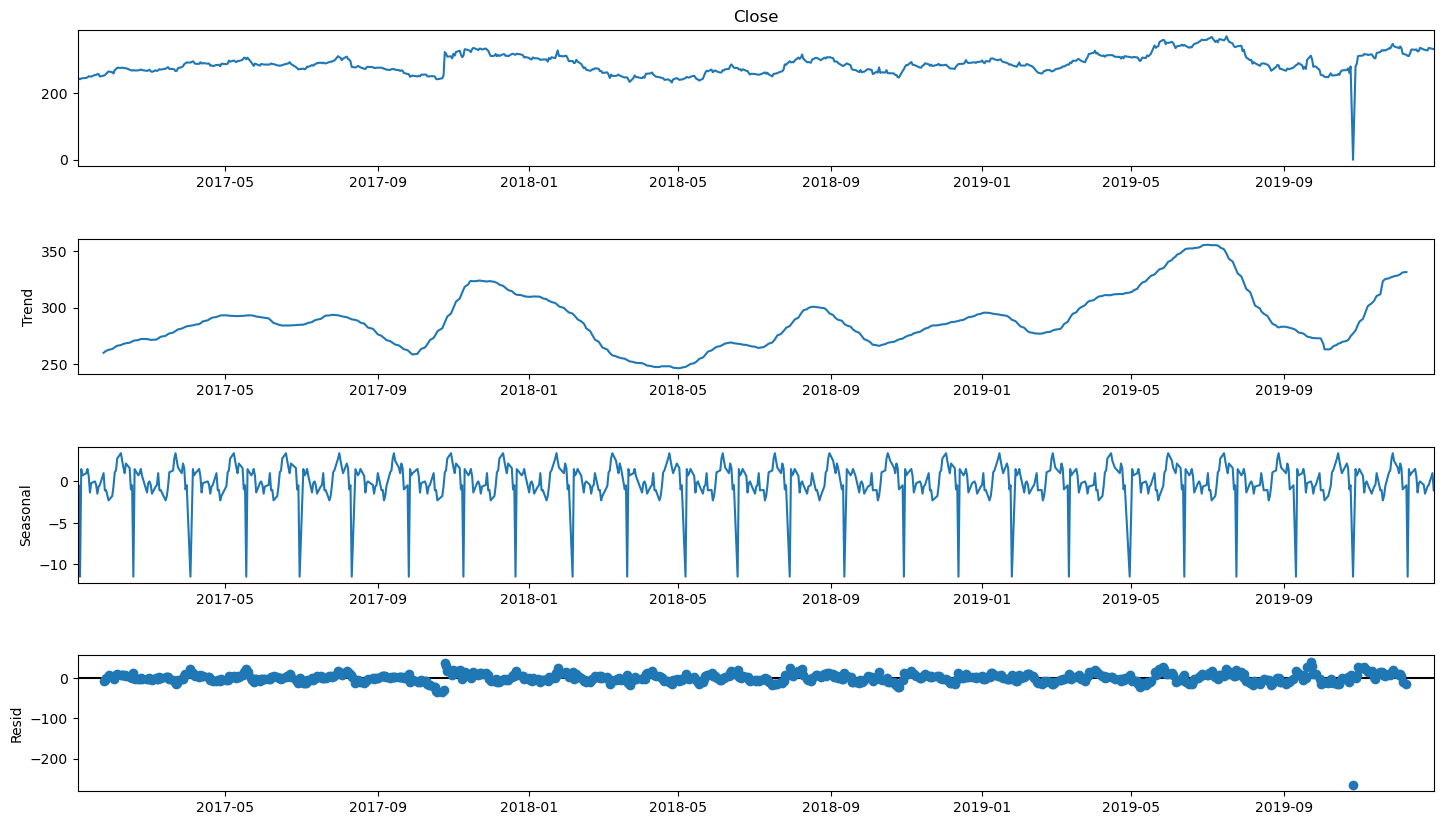

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='additive', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


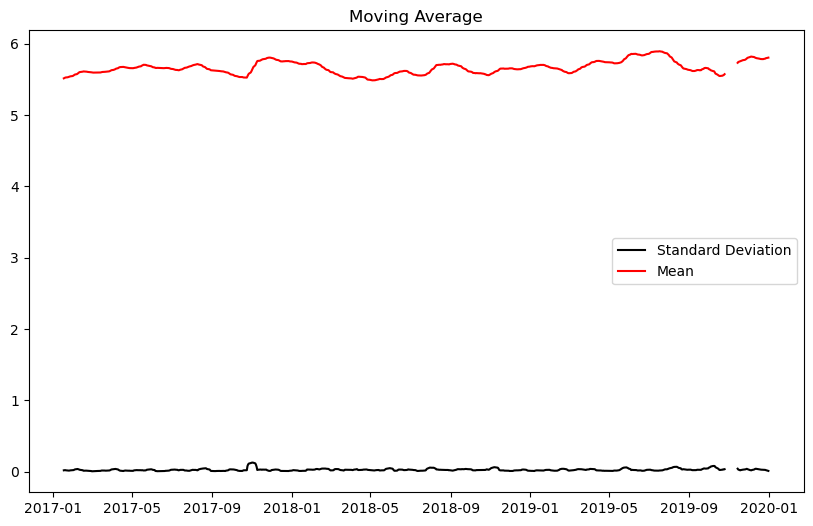

In [9]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

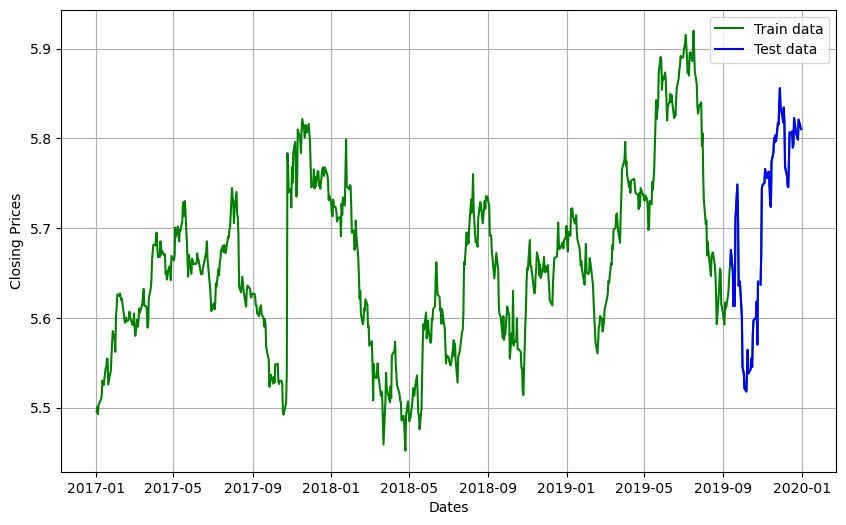

In [10]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3273.201, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3271.202, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3271.201, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3275.116, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3269.201, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.578 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  660
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1638.558
Date:                Fri, 16 Jun 2023   AIC                          -3275.116
Time:                        09:57:32   BIC                          -3270.625
Sample:                             0   HQIC                         -3273.375
                                - 660                                  

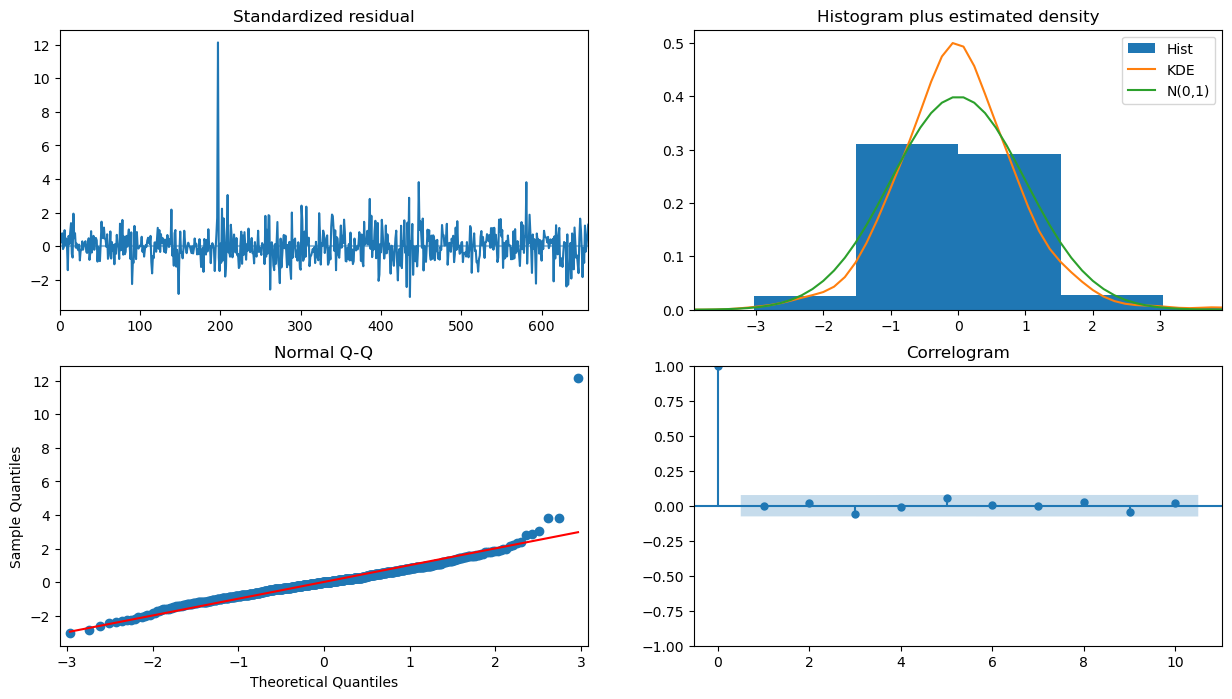

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [12]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  660
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1638.936
Date:                Fri, 16 Jun 2023   AIC                          -3269.872
Time:                        09:57:40   BIC                          -3251.909
Sample:                             0   HQIC                         -3262.909
                                - 660                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2582      1.042     -0.248      0.804      -2.300       1.784
ma.L1          0.2627      1.046      0.251      0.802      -1.788       2.313
ma.L2          0.0356      0.033      1.083      0.2

In [13]:
# Forecast
fc = fitted.forecast(321, alpha=0.005)  # 95% conf
fc1 = fc.to_frame()
fc1.iloc[:,0]

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


660    5.653960
661    5.654715
662    5.654520
663    5.654571
664    5.654558
         ...   
976    5.654560
977    5.654560
978    5.654560
979    5.654560
980    5.654560
Name: predicted_mean, Length: 321, dtype: float64

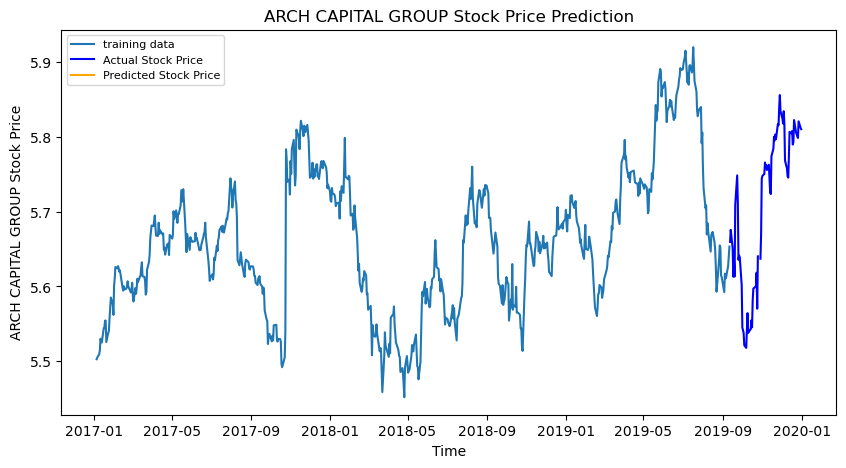

In [16]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(fc1.iloc[:,0], index=test_data.index)
upper_series = pd.Series(fc1.iloc[:,0], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))